In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/All_Accepted_44.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,delinq_2yrs,mths_since_last_delinq,acc_now_delinq,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,NONE,OTHER,OWN,RENT,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,-1.239239,-0.307239,-1.446628,-0.663160,-0.663151,0.163792,-1.203010,-0.840635,-1.000430,-0.603176,-0.362263,0.563076,-0.065598,-0.356859,-0.522937,-0.560026,0.853561,0.199479,0.361317,1.124204,-0.014724,1.017814,-0.005904,-0.010447,-0.347838,-0.817406,-0.104967,-0.531727,0.852241,-0.01572,-0.26315,-0.073474,-0.149723,-0.107582,-0.0842,-0.247959,-0.026386,-0.107880,-0.082564,-0.041732,1.523538,-0.798653,-0.669432,1.0
1,1.197526,-0.165064,-0.233691,0.598399,0.598384,-0.257756,1.480721,1.899426,1.082545,0.232773,0.776085,-0.477117,-0.065598,-0.356859,-0.034138,-0.560026,0.853561,0.199479,-0.104144,1.124204,-0.014724,1.017814,-0.005904,-0.010447,-0.347838,-0.817406,-0.104967,-0.531727,-1.173377,-0.01572,-0.26315,-0.073474,-0.149723,-0.107582,-0.0842,-0.247959,-0.026386,9.269533,-0.082564,-0.041732,1.523538,-0.798653,-0.669432,1.0
2,-0.453931,0.395575,0.878865,-0.032380,-0.032384,1.946941,-0.560685,0.072718,0.832588,0.253287,0.776085,-0.217069,-0.065598,-0.356859,0.165825,1.785632,0.853561,2.517044,2.223161,-0.660074,-0.014724,1.017814,-0.005904,-0.010447,-0.347838,-0.817406,-0.104967,-0.531727,-1.173377,-0.01572,-0.26315,-0.073474,6.678987,-0.107582,-0.0842,-0.247959,-0.026386,-0.107880,-0.082564,-0.041732,-0.656367,1.252108,-0.669432,1.0
3,-0.274927,-0.605807,-0.933968,-0.190075,-0.190075,0.047867,-0.117009,-1.205977,-1.583663,-0.332481,-0.362263,-0.737165,-0.065598,-0.356859,1.587785,-0.560026,0.853561,0.199479,0.206163,-0.405177,-0.014724,-0.982498,-0.005904,-0.010447,-0.347838,1.223383,-0.104967,-0.531727,0.852241,-0.01572,-0.26315,-0.073474,-0.149723,-0.107582,-0.0842,-0.247959,-0.026386,-0.107880,-0.082564,-0.041732,-0.656367,1.252108,-0.669432,1.0
4,0.654739,1.469949,-0.399798,-0.505465,-0.505459,-0.852138,0.777504,0.072718,0.166036,3.176092,-0.362263,1.386562,-0.065598,-0.356859,1.232295,-0.560026,-1.171562,-0.573042,-0.724759,1.124204,-0.014724,1.017814,-0.005904,-0.010447,-0.347838,-0.817406,-0.104967,-0.531727,0.852241,-0.01572,-0.26315,-0.073474,-0.149723,-0.107582,-0.0842,-0.247959,-0.026386,-0.107880,-0.082564,-0.041732,1.523538,-0.798653,-0.669432,1.0


In [4]:
data.shape

(1319510, 44)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    1057295
0.0     262215
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(1319510, 43)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.80326788 0.8026957  0.80326788 0.80341187 0.80355208]
0.8032390811740722


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  22312,  239903],
       [  19725, 1037570]])

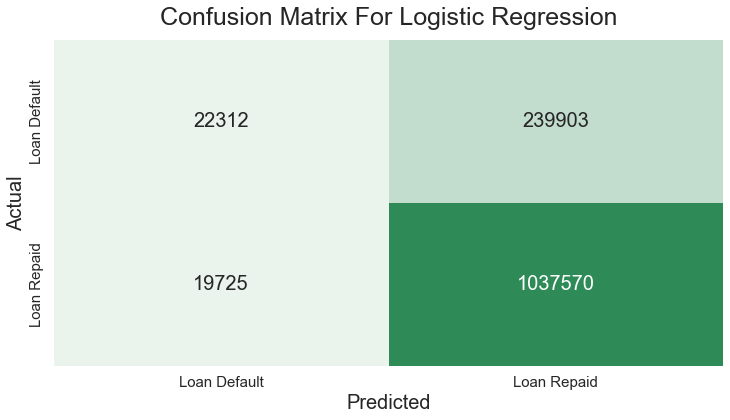

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.8032390811740722

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

1037570
239903
19725
22312
0.8032390811740722


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    1057295
0.0     262215
Name: loan_status_bin, dtype: int64

0.801278504899546


In [17]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 1.1% better than Null Model or "random investment"
TP / (TP+FP)

0.8122050329048051

In [18]:
#What if we "balance" the weight class to avoid "imbalanced" nature...No Change! 

In [19]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [20]:
steps_balanced = [('model', lr_balanced)]
pipeline_balanced = Pipeline(steps=steps)

In [21]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline_balanced, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.80326788 0.8026957  0.80326788 0.80341187 0.80355208]
0.8032390811740722


In [22]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred_balanced = cross_val_predict(pipeline_balanced, X, y, cv=cv, n_jobs=-1)
conf_mat_balanced = confusion_matrix(y, y_pred_balanced)
conf_mat_balanced

array([[  22312,  239903],
       [  19725, 1037570]])

In [23]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [24]:
y_pred_prob

array([[0.11875677, 0.88124323],
       [0.18076608, 0.81923392],
       [0.45488296, 0.54511704],
       ...,
       [0.14993458, 0.85006542],
       [0.26753885, 0.73246115],
       [0.2941174 , 0.7058826 ]])

In [25]:
#Obtaining classification based on desired threshold of 0.5 (Same as standard Logistic Regression): 

y_pred_success = (y_pred_prob[:, 1] > 0.50).astype('float')
y_pred_success

array([1., 1., 1., ..., 1., 1., 1.])

In [26]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[  22312,  239903],
       [  19725, 1037570]])

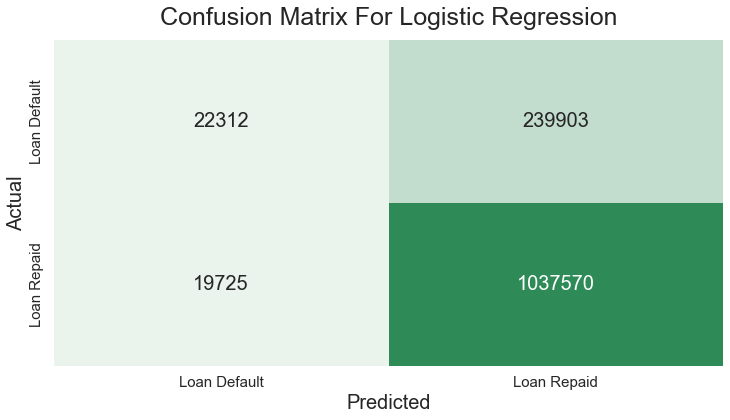

In [27]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [28]:
accuracy_score(y, y_pred_success)

0.8032390811740722

In [29]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

1037570
239903
19725
22312
0.8032390811740722


In [30]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8122050329048051

In [31]:
thresh = []
PosPredVal = []

for i in range(0,100,1):
    y_pred_success = (y_pred_prob[:, 1] > (i/100)).astype('float')
    conf_mat = confusion_matrix(y, y_pred_success)
    TN, FP, FN, TP = conf_mat.ravel()
    thresh.append(i)
    PosPredVal.append((TP/(TP+FP)))

print(np.max(PosPredVal))
print(PosPredVal.index(np.max(PosPredVal)))

0.9741251516104398
96


In [32]:
PosPredVal

[0.801278504899546,
 0.801278504899546,
 0.801278504899546,
 0.801278504899546,
 0.801278504899546,
 0.801278504899546,
 0.801278504899546,
 0.801278504899546,
 0.801278504899546,
 0.801278504899546,
 0.801278504899546,
 0.801278504899546,
 0.8012791121545969,
 0.8012791121545969,
 0.8012797194105682,
 0.8012803266674599,
 0.8012815411840046,
 0.8012813905831282,
 0.8012830617658204,
 0.8012862535629269,
 0.8012911166385495,
 0.8012990211867779,
 0.8013075382780088,
 0.8013347329965551,
 0.8013582960660957,
 0.8013943277830082,
 0.801439639748916,
 0.8015033922619427,
 0.8015893780585744,
 0.801680475940157,
 0.801799477668904,
 0.8019359495648174,
 0.8021097360400078,
 0.8023110496586985,
 0.8025338701990138,
 0.8027961921279129,
 0.8030866721021815,
 0.8034218967868763,
 0.8038186710926964,
 0.8042310952282775,
 0.8046890053124627,
 0.8052051868101577,
 0.8057917859323277,
 0.8064165378266976,
 0.8071028860575487,
 0.8078185346806647,
 0.8086083171600892,
 0.8094290059664196,
 0.8103

In [33]:
#Obtaining classification based on desired threshold of 0.9: 

y_pred_success = (y_pred_prob[:, 1] > 0.92).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [34]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[253862,   8353],
       [894545, 162750]])

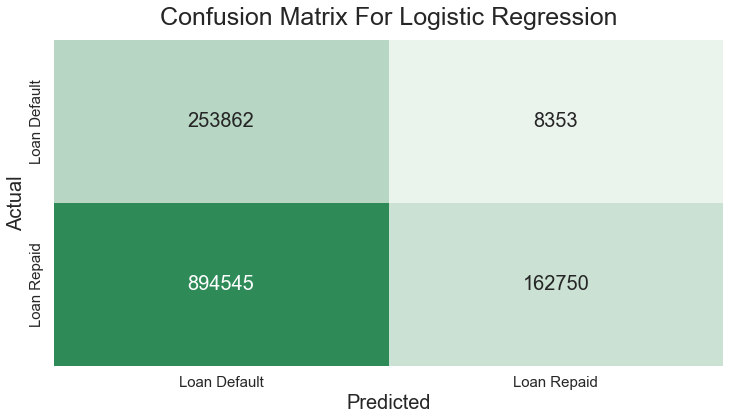

In [35]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [30]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [31]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 